In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
batch_size = 32
img_height = 224
img_width = 224

In [ ]:

data_dir = '/content/drive/MyDrive/DataSet Grad Project/dataset_1/training'

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1840 files belonging to 2 classes.
Using 1472 files for training.


In [ ]:

data_dir1 = '/content/drive/MyDrive/DataSet Grad Project/dataset_1/validation'

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir1,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 460 files belonging to 2 classes.
Using 92 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['00-damage', '01-whole']


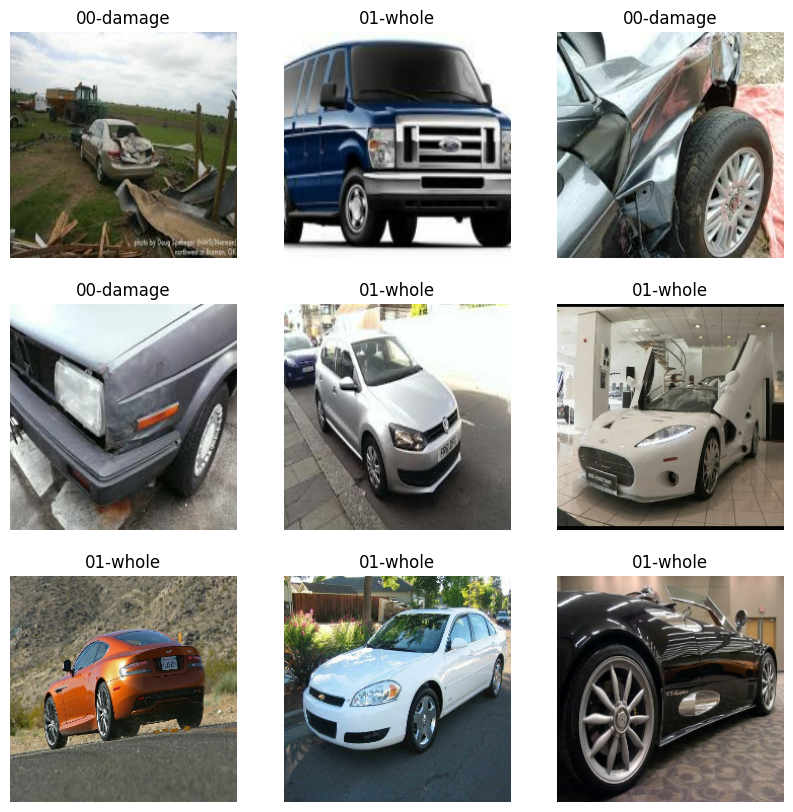

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
from tensorflow.keras import callbacks
from tensorflow.keras import layers, regularizers


num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),


  layers.Flatten(),

  layers.Dense(512, activation='relu'),  # Additional dense layer
  layers.Dense(num_classes,activation='softmax')
])

In [ ]:

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 112, 112, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 56, 56, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 56, 56, 64)       

In [ ]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10


ValueError: ignored

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score


# Evaluate the model on the validation set
val_results = model.evaluate(val_ds)

# Calculate predictions and ground truth labels for the validation set
val_predictions = model.predict(val_ds)
val_labels = []
for images, labels in val_ds:
    val_labels.extend(np.argmax(labels, axis=1))

# Calculate precision, recall, F1-score, and confusion matrix
val_precision = precision_score(val_labels, np.argmax(val_predictions, axis=1), average='weighted')
val_recall = recall_score(val_labels, np.argmax(val_predictions, axis=1), average='weighted')
val_f1_score = f1_score(val_labels, np.argmax(val_predictions, axis=1), average='weighted')
val_confusion_matrix = confusion_matrix(val_labels, np.argmax(val_predictions, axis=1))

print("Validation Loss:", val_results[0])
print("Validation Accuracy:", val_results[1])
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print("Validation F1-Score:", val_f1_score)
print("Validation Confusion Matrix:\n", val_confusion_matrix)

# Display classification report
class_report = classification_report(val_labels, np.argmax(val_predictions, axis=1), target_names=class_names)
print(class_report)


In [ ]:
car_damage_url = "/content/drive/MyDrive/DataSet Grad Project/CDV5_2/test/images/0006_JPEG.rf.c0ead6b03c9f428fd75fd390319dc120.jpg"


img = tf.keras.utils.load_img(
    car_damage_url, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
# Get the predicted labels for the validation dataset
val_pred = np.argmax(model.predict(val_ds), axis=-1)

# Get the true labels for the validation dataset
val_true = np.concatenate([labels for _, labels in val_ds], axis=0)

# Calculate precision, F1 score, and confusion matrix
precision, recall, f1, _ = classification_report(val_true, val_pred, target_names=class_names, output_dict=True)["weighted avg"]
confusion_mat = confusion_matrix(val_true, val_pred)

print("Precision:", precision)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion_mat)

In [ ]:
confidence_threshold = 0.60

if np.max(score) > confidence_threshold:
    predicted_class_index = np.argmax(score)
    predicted_class = class_names[predicted_class_index]
    confidence = 100 * np.max(score)
    print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(predicted_class, confidence))
else:
    print("The confidence level is below the threshold.")

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess the test image
img_path = '/content/drive/MyDrive/Yolov8_Metrics/car_damage_1.jpeg'
img = image.load_img(img_path, target_size=(img_height, img_width))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img /= 255.0

# Get the predicted probabilities for each class
predictions = model.predict(img)

# Define a threshold for classification (adjust this as needed)
threshold = 0.9

# Classify based on the threshold
predicted_class = (predictions[0, 1] >= threshold).astype(int)  # Class 1 if >= threshold, Class 0 otherwise

class_labels = train_ds.class_indices

class_labels = {v: k for k, v in class_labels.items()}

predicted_class_label = class_labels[predicted_class]

# Print the predicted class label and probability score
print("Predicted Class:", predicted_class_label)
print("Probability Score:", predictions[0, 1])

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

# Collect the true labels for the validation data
true_labels = []
predicted_classes = []

for i in range(len(val_gen)):
    batch_images, batch_labels = next(val_gen)
    true_labels.extend(batch_labels.argmax(axis=1))
    predicted_classes.extend(model.predict(batch_images).argmax(axis=1))

# Calculate the F1 score, precision, recall, and confusion matrix
f1_score_value = f1_score(true_labels, predicted_classes, average='weighted')
precision = precision_score(true_labels, predicted_classes, average='weighted')
recall = recall_score(true_labels, predicted_classes, average='weighted')
conf_matrix = confusion_matrix(true_labels, predicted_classes)

print("F1 Score:", f1_score_value)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", conf_matrix)

# Generate a classification report
report = classification_report(true_labels, predicted_classes, target_names=class_labels.values())

print("Classification Report:\n", report)